<a href="https://colab.research.google.com/github/tenomoto/hotspot2-niigata-20211023/blob/main/python_20211023_niigata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Python環境

- Conda: よく使われているがおすすめしない。
    - 知らないうちに環境変数が設定される。
    - pipとの二重管理になる。
- Windows: 本家インストーラがおすすめ。
    - Christoph Gohlkeさんの[バイナリ](https://www.lfd.uci.edu/~gohlke/pythonlibs/)
    - WSL2
- macOS: [MacPorts](https://www.macports.org)がおすすめ
    - Python以外のライブラリ等もインストールできる。
    - 本家についていっている。
    - ないものは`pip install --user`
- ソースからのコンパイルも簡単

```
% ./configure --prefix=${HOME}/.local --enable-optimizations
```

# 海面水温

気象庁の[MGDSST](https://www.data.jma.go.jp/gmd/goos/data/pub/JMA-product)を可視化してみよう。 

- ファイルは日別，解像度は0.125度。
- データは北から南に，グリニッジ子午線から東向き。
- 最初の行はデータの日，月，年，行と列の数
- 2行目の1列目が東経0.125度, 北緯89.875度
- 最後の721行目の1440列目が東経359.875度, 南緯89.875度



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr


nlon, nlat = 1440, 720
lon = np.linspace(0.125, 359.875, nlon)
lat = np.linspace(89.875, -89.875, nlat)

In [2]:
year = 2021
month = 10
day = 10
fname = f"mgd_sst_glb_D{year}{month:02}{day:02}.txt.gz"
url = f"http://www.data.jma.go.jp/gmd/goos/data/pub/JMA-product/mgd_sst_glb_D/{year}/{fname}"

In [3]:
!curl -O $url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  360k  100  360k    0     0   392k      0 --:--:-- --:--:-- --:--:--  391k


## pandas

- 表の行や列にラベルをつけて，統計処理をするためのライブラリ。
- MGDSSTの各要素は長さ3文字の固定長になので`pandas.read_fwf()`を使う。
- ヘッダ行を`skiprows`で一つ読み飛ばす。
- ヘッダ行なし（`header=None`）で180行（`nrows=nlat`）読む。
- `888`と`999`はそれぞれ海氷と陸を表しているので非数とする。
- ファイルはgzip圧縮されているので`compression=”gzip”`を指定。

In [4]:
df = pd.read_fwf(fname, widths=[3]*nlon, skiprows=1, header=None,
                 na_values=[888, 999], nrows=nlat, compression="gzip")

## xarray

- ラベルつきの多次元データを扱うライブラリ。
- Numpyの配列にpandasのようなラベルをつけて扱うことが可能。
- データは10倍した整数0.1倍。ただし2019年以前の再解析データの場合は0.1倍されてない。
- 海面水温データに対しては，経度と緯度を付加。
- xarrayの`DataArray`も`plot()`メソッドでデータを可視化。

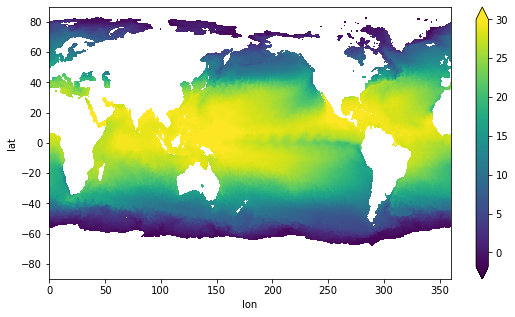

In [5]:
sst = xr.DataArray(df * 0.1, dims=["lat", "lon"], coords={"lat":lat, "lon":lon})
sst.plot(figsize=[9,5], vmin=-1.8, vmax=30)
plt.show()

# 再解析データ

- 比較的新しい予報モデルに対して過去の観測データを同化したデータセット。
- NCEP/NCAR再解析（[Kalnay et al. 1996](https://doi.org/10.1175/1520-0477(1996)077%3C0437:TNYRP%3E2.0.CO;2)）はモデルも同化手法も古いがサイズが小さく入手が容易。
- データと共に座標などのメタデータが一つのファイルに保存されたNetCDF形式。
- データを読むには`xarray.open_dataset()`を用いる。

In [6]:
!curl -O http://database.rish.kyoto-u.ac.jp/arch/ncep/data/ncep.reanalysis.derived/surface/slp.mon.mean.nc

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 19.3M  100 19.3M    0     0  7678k      0  0:00:02  0:00:02 --:--:-- 7675k


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr


ds = xr.open_dataset("slp.mon.mean.nc")

`ds`を印字してメタ情報を確認。

In [8]:
ds

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 144, time: 885)
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2021-09-01
Data variables:
    slp      (time, lat, lon) float32 ...
Attributes:
    description:    Data is from NMC initialized reanalysis\n(4x/day).  These...
    platform:       Model
    Conventions:    COARDS
    NCO:            20121012
    history:        Thu May  4 18:12:35 2000: ncrcat -d time,0,622 /Datasets/...
    title:          monthly mean slp from the NCEP Reanalysis
    dataset_title:  NCEP-NCAR Reanalysis 1
    References:     http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis...

## 海面気圧の年々変動

- `.sel()`メソッドで新潟に付近の東経137.5度，北緯37.5度を指定。
-  添え字は0から始まるので毎年の10月は`[9::12]`

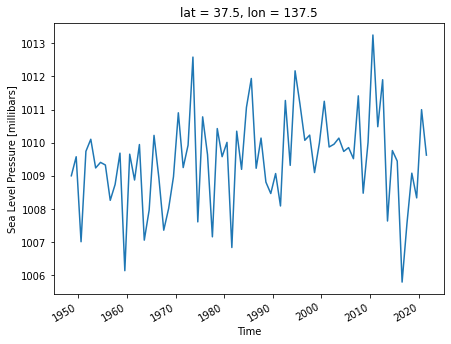

In [9]:
ds.slp.sel(lon=137.5, lat=37.5)[7::12].plot(figsize=[7,5])
plt.show()

## 海岸線の描画

- 地図投影にはCartopyを用いる。
- CartopyはPython以外で書かれた外部ライブラリに依存。
- apt-getとpipを使って依存ライブラリとCartopyをインストール。
- Cartopyは初めて必要となったときに海岸線等のデータをダウンロード。
- サーバがダウンしているとデータが取得できないときは，GSHHSのデータを使う。

```
import cartopy.feature as cfeature

ax.add_feature(cfeature.GSHHSFeature())
```

In [10]:
!pip uninstall --yes shapely
!pip install shapely --no-binary shapely
!pip install cartopy

Found existing installation: Shapely 1.7.1
Uninstalling Shapely-1.7.1:
  Successfully uninstalled Shapely-1.7.1
  Using cached Shapely-1.7.1.tar.gz (383 kB)
Skipping wheel build for shapely, due to binaries being disabled for it.
    Running setup.py install for shapely ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


## 正射図法

- 5行目: 経度方向が周期的になるように`add_cyclic_point`で点を追加。
- 8行目: 投影をprojectionに指定。 `ccrs.Orthographic()`は正射図法で衛星から地球を眺めたような投影法。
- 10行目: 描画関数に与える`transform`は，データが定義されている座標系。


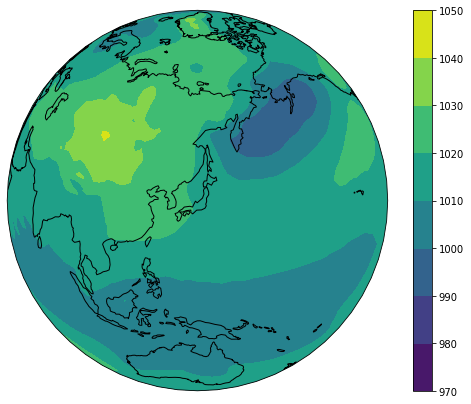

In [11]:
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

wdata, wlon = add_cyclic_point(ds.slp.sel(time="2021-1")[0], ds.lon)

fig = plt.figure(figsize=[9, 7])
ax = fig.add_subplot(111, projection=ccrs.Orthographic(137.5,37.5))

p = ax.contourf(wlon, ds.lat, wdata, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
fig.colorbar(p)
plt.show()

## 日本域

- 5行目: ccrs.LambertConformal()はランベルト図法。
- 7～9行目: NaturalEarthの海，湖水，陸のデータ。

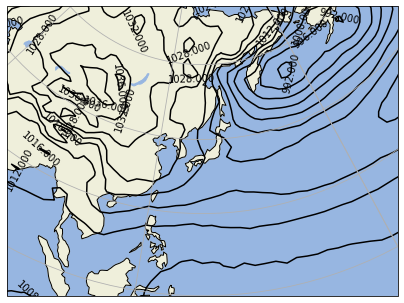

In [12]:
import cartopy.feature as cfeature


fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111, projection=ccrs.LambertConformal(135,35))

ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.LAND)
ax.coastlines()
p = ax.contour(wlon, ds.lat, wdata,
               levels=np.arange(960, 1040, 4), colors=["k"],
               transform=ccrs.PlateCarree())
ax.clabel(p, manual=False, inline=True)
ax.set_extent([90, 180, 0, 70], ccrs.PlateCarree())
ax.gridlines()
plt.show()

# 年々変動

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr


ds = xr.open_dataset("slp.mon.mean.nc")

## 平均と標準偏差

In [14]:
slp = ds.slp[11::12]
slp_clim = slp.mean(axis=0)
slp_stddev = slp.std(axis=0)

## 描画関数の定義



In [15]:
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point


def plot_nps(lon, lat, data):
    datac, lonc = add_cyclic_point(data, lon)
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection=ccrs.NorthPolarStereo(135))
    p = ax.contourf(lonc, lat, datac, transform=ccrs.PlateCarree())
    ax.set_extent([0, 359.999, 20, 90], ccrs.PlateCarree())
    fig.colorbar(p)
    ax.coastlines()

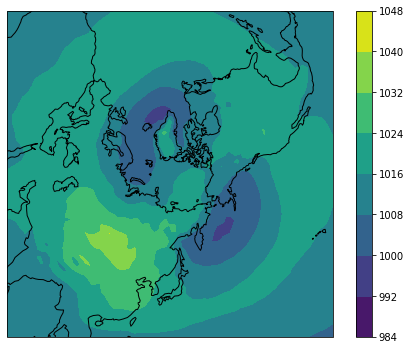

In [16]:
plot_nps(ds.lon, ds.lat, slp_clim)

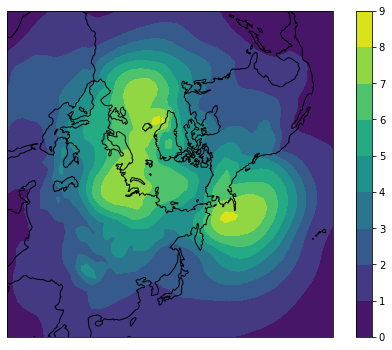

In [17]:
plot_nps(ds.lon, ds.lat, slp_stddev)

## 特異値分解

$$
\mathbf{X} = \mathbf{USV}^\mathrm{T}
$$

- $\mathbf{V}$の列が固有ベクトル，$\mathbf{S}$の対角成分の2乗が固有値。
- $\mathbf{X}$の列は偏差は各年の値から平年値を引いた値。
- データには緯度の重みを掛ける。
- 共分散行列は偏差の2乗
- 偏差の重みは平方根$\sqrt{\cos\phi}$。

In [18]:
wgt = np.sqrt(np.abs(np.cos(np.deg2rad(ds.lat))))

- xarrayでは`wgt`のラベル`lat`を利用してブロードキャスト
- `where`メソッドで北緯20度より極よりのデータを選択。 
- `drop=True`で`np.NaN`を落す。 
- 空間を1次元化，転置
- 各年の偏差を列ベクトルとする行列にする。

In [19]:
dslp = (slp - slp_clim) / slp_stddev
X = dslp * wgt
X = (X.where(ds.lat>20, drop=True)).data.reshape(X.shape[0],-1).transpose()

In [20]:
U, s, V = np.linalg.svd(X)

## 寄与率


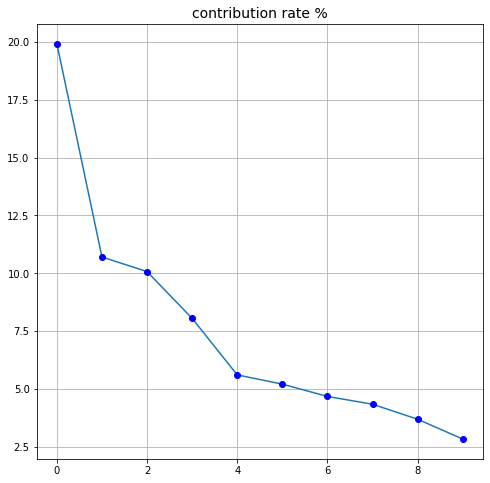

In [21]:
contrib = (s * s) / (s @ s) * 100

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(contrib[0:10])
ax.plot(contrib[0:10],'bo')
ax.set_title("contribution rate %", fontsize=14)
ax.grid()
plt.show()

## 回帰

In [22]:
D = (dslp.data.transpose() @ V.transpose()).transpose()

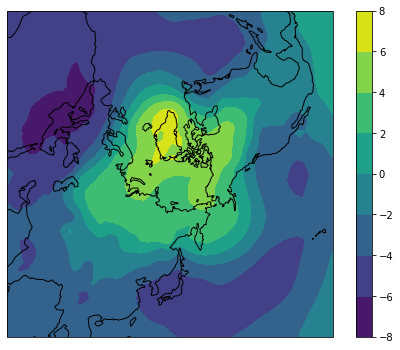

In [23]:
plot_nps(ds.lon, ds.lat, D[0])

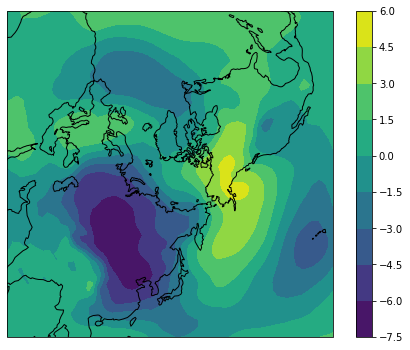

In [24]:
plot_nps(ds.lon, ds.lat, D[1])

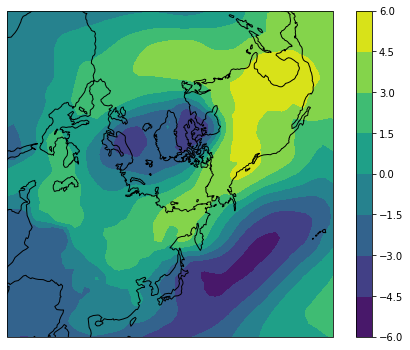

In [25]:
plot_nps(ds.lon, ds.lat, D[2])